In [ ]:
! pip install SALib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00


In [ ]:
import sys

from SALib.sample import saltelli,finite_diff, fast_sampler
from SALib.analyze import morris,sobol, dgsm, fast, delta
from SALib.util import read_param_file
from SALib.sample.morris import sample
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, sample_histograms

import numpy as np
import pandas
import math


from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error,f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
import copy
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch import nn, Tensor, optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models

import json,pickle

from skimage.color import gray2rgb, rgb2gray, label2rgb
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Neural Network Layer
        self.convolutaional_neural_network_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers
                # We can calculate the output size of each convolutional layer using the following formular
                # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28)
                nn.ReLU(),
                # After the first convolutional layer the output of this layer is:
                # [(28 + 2*1 - 3)/1] + 1 = 28.
                nn.MaxPool2d(kernel_size=2),
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 28 / 2 = 14

                # output of our second conv layer
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the second convolutional layer the output of this layer is:
                # [(14 + 2*1 - 3)/1] + 1 = 14.
                nn.MaxPool2d(kernel_size=2)
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                # We have the output_channel=24 of our second conv layer, and 7*7 is derived by the formular
                # which is the output of each convolutional layer
                nn.Linear(in_features=24*7*7, out_features=64),
                nn.ReLU(),
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=64, out_features=10) # The output is 10 which should match the size of our class
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)
        # The softmax function returns the prob likelihood of getting the input image.
        # We will see a much graphical demonstration below
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# load the model
model_path = "/content/drive/MyDrive/paper_data/cnn_mnist.pth"
model = Network()
model.to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])
    return transform

def get_input_tensors(img):

    # img = torch.from_numpy(img)
    # img = img.to(device)
    transf = get_input_transform()
    img = transf(img)
    img = img.detach().cpu().numpy()
    return img

In [ ]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])

# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=60000, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=10000, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5069871.11it/s]


Extracting DATA_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134771.47it/s]


Extracting DATA_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1269289.73it/s]


Extracting DATA_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8659331.26it/s]

Extracting DATA_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



In [ ]:
train_data = enumerate(trainloader)
_, (images, labels) = next(train_data)

# dataiter = iter(testloader)
# images, labels = dataiter.next()
print(type(images)) # Checking the datatype
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([60000, 1, 28, 28])
torch.Size([60000])


In [ ]:
images_train = Tensor.cpu(images)
labels_train = Tensor.cpu(labels)

images_train = images_train.numpy().reshape((-1, 784))
labels_train = labels_train.numpy()

X_vec_train = np.stack([iimg for iimg in images_train.reshape((-1, 28, 28))],0)
y_vec_train = labels_train.astype(np.uint8)

X_vec_train.shape

(60000, 28, 28)

In [ ]:
test_data = enumerate(testloader)
_, (images, labels) = next(test_data)
print(type(images)) # Checking the datatype
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

images_test = Tensor.cpu(images)
labels_test = Tensor.cpu(labels)

images_test = images_test.numpy().reshape((-1, 784))
labels_test = labels_test.numpy()

X_vec_test = np.stack([iimg for iimg in images_test.reshape((-1, 28, 28))],0)
y_vec_test = labels_test.astype(np.uint8)

X_vec_test.shape

<class 'torch.Tensor'>
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


(10000, 28, 28)

In [ ]:
# dataiter = iter(testloader)
# X_vec_test, y_vec_test = dataiter.next()

In [ ]:
def extract_feats(imgs):
    imgs = imgs.astype(np.float32)
    tensor_vec = np.reshape(imgs, (1, 1, 28, 28))
    # tensor_vec = np.stack([rgb2gray(iimg).reshape((1, 28, 28)) for iimg in imgs], 0) # (-1, 28, 28, 3) -> (-1, 1, 28, 28)
    images = torch.from_numpy(tensor_vec)
    images = images.to(device)
    # model.eval()
    logits = model(images)
    features = logits.cpu().detach().numpy()
    return features

In [ ]:
# model function for prediction
def batch_predict(imgs):
    imgs = imgs.astype(np.float32)
    tensor_vec = np.reshape(imgs, (1, 1, 28, 28))
    # tensor_vec = np.stack([rgb2gray(iimg).reshape((1, 28, 28)) for iimg in imgs], 0) # (-1, 28, 28, 3) -> (-1, 1, 28, 28)
    images = torch.from_numpy(tensor_vec)
    images = images.to(device)
    model.eval()
    logits = model(images)
    # print('log',logits)
    # print('im',images)
    probs = F.softmax(logits, dim=1)
    # print('prob',probs)
    test_preds = probs.detach().cpu().numpy()
    # print('pred',test_preds)
    return test_preds[0]

In [ ]:
feature_labels = [f'f {i}' for i in range(784)]

In [ ]:
problem = {
  'num_vars': 784,
  'names': feature_labels,
  'bounds': [[-0.42421296, 2.8214867]]*784 #standard scaled, bounds are within min and max pixel values of train images
}

In [ ]:
## 1- Morris
from SALib.analyze import morris
X = sample(problem, N=50, num_levels=4, optimal_trajectories=None)

In [ ]:
X.shape

(39250, 784)

In [ ]:
# evaluation of the samples generated by Morris sampling
X_img = X.reshape((-1,28,28))
pred_list = []
for img in X_img:
    pred_list.append(batch_predict(img))# model function for prediction
pred_list = np.asarray(pred_list)
model_predict_test = np.argmax(pred_list,axis = 1)
# print(model_predict_test)

In [ ]:
Y = model_predict_test
Y = np.float64(Y)
Y = np.nan_to_num(Y).flatten()
from SALib.sample.morris import sample


si_morris = morris.analyze(problem, X, Y, conf_level=0.95,
                    print_to_console=False,
                    num_levels=4, num_resamples=100)

In [ ]:
si_morris.keys()

dict_keys(['names', 'mu', 'mu_star', 'sigma', 'mu_star_conf'])

In [ ]:
mustar_ind = si_morris['mu_star'].reshape((28,28))
mustarconf_ind = si_morris['mu_star_conf'].reshape((28,28))
sigma_ind = si_morris['sigma'].reshape((28,28))
mu_ind = si_morris['mu'].reshape((28,28))

In [ ]:
with open("/content/drive/MyDrive/paper_data/ccr/mnist_morris_index1.pkl", 'wb') as handle:
    pickle.dump(mustar_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/paper_data/ccr/mnist_morris_index2.pkl", 'wb') as handle:
    pickle.dump(sigma_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/paper_data/ccr/mnist_morris_index3.pkl", 'wb') as handle:
    pickle.dump(mu_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)

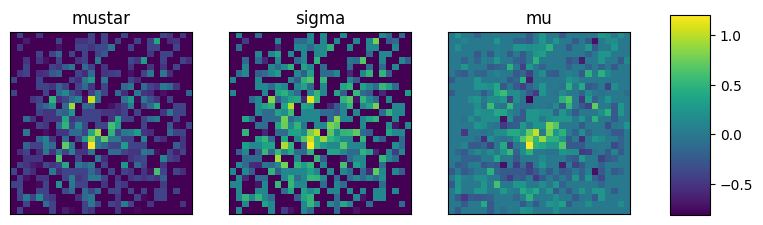

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(8,8))
ax[0].imshow(mustar_ind)
ax[0].set_title('mustar')
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
# ax[1].imshow(mustarconf_ind)
# ax[1].set_title('mustarconf')
# ax[1].get_xaxis().set_ticks([])
# ax[1].get_yaxis().set_ticks([])
ax[1].imshow(sigma_ind)
ax[1].set_title('sigma')
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
a2 = ax[2].imshow(mu_ind)
ax[2].set_title('mu')
ax[2].get_xaxis().set_ticks([])
ax[2].get_yaxis().set_ticks([])

cbar_ax = fig.add_axes([0.95, 0.38, 0.05, 0.25])
fig.colorbar(a2, cax=cbar_ax)

file_name = '/content/drive/MyDrive/paper_data/ccr/mnist_SA_morris_sal'
fig.savefig(file_name,
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200,
            format='png')

In [ ]:
def sort_Si(Si, key, sortby):
    # vals = np.array([Si[key][x] for x in np.argsort(-Si[sortby])]) #descendlingly
    vals = np.array([Si[key][x] for x in np.argsort(Si[sortby])])  #ascendingly
    inds = np.argsort(Si[sortby])
    return vals,inds

In [ ]:
names_sorted = sort_Si(si_morris, 'names', sortby='mu_star')
mu_star_sorted, mu_star_sorted_ind = sort_Si(si_morris, 'mu_star', sortby='mu_star')
sigma_sorted, sigma_sorted_ind = sort_Si(si_morris, 'sigma', sortby='sigma')
mu_star_conf_sorted, mu_star_conf_sorted_ind = sort_Si(si_morris, 'mu_star_conf', sortby='mu_star_conf')
mu_sorted,mu_sorted_ind = sort_Si(si_morris, 'mu', sortby='mu')


In [ ]:
# sorted ascendingly
print(mu_star_sorted[-5:])
print(sigma_sorted[-5:])

[0.715 0.78  0.845 0.865 0.885]
[2.79325663 2.90698616 3.02721353 3.0346618  3.10845352]


In [ ]:
images_test = images_test.reshape((-1, 784))
labels_test = labels_test

In [ ]:
def eval_sample(x_test, x_dl, target):
    pred_test = batch_predict(x_test)
    pred_dl = batch_predict(x_dl)
    diff = -1; success =0
    class_test = np.argmax(pred_test)
    class_dl = np.argmax(pred_dl)
    if class_dl == target:
        diff = np.max(pred_dl) - np.max(pred_test)
        success = 1
        # print(f"diff is {diff}")
        # print(f"successful")
    else:
        # print(f"Error in classification for target {target}")
        success = 0
    return diff, success, pred_test, pred_dl, class_dl

In [ ]:
    imp_thresh = [784,684,584,484,384,284,184,84]
    for imp_th in imp_thresh[::-1]:
        print(imp_th)

84
184
284
384
484
584
684
784


In [ ]:
#measures the effect of sorted portion of each factor (for examples mu, mu-star, sigma) based on accuracy of classification
def measurement(factor):

    ccr_imp = [] ;  ccr_imp_inv = []


    num_class = 10
    # prec_rec_dict = {i:[] for i in range(num_class)}

    # imp_thresh = [784,684,584,484,384,284,184,84]
    imp_thresh = [84,184,284,384,484,584,684,784]
    # for imp_th in imp_thresh[::-1]:
    for imp_th in imp_thresh:
        probs_X = {i:[] for i in range(0,9)}
        probs_Xf = {i:[] for i in range(0,9)}

        probs_X_inv = {i:[] for i in range(0,9)}
        probs_Xf_inv = {i:[] for i in range(0,9)}

        all_classes_true = []
        all_classes_pred = []; all_classes_pred_inv = []

        for ind in range(num_class):
            # print('------class number------',ind)

            indices = np.where(y_vec_test==ind)[0]

            images_class = images_test[indices]
            # images_class_mask = X_vec_test_mask[indices]

            images_class_labels = labels_test[indices]

            num_imgs = len(images_class)
            # print('num_imgs',num_imgs)

            probs_X[ind] = np.zeros((num_imgs, num_class))
            probs_X_inv[ind] = np.zeros((num_imgs, num_class))

            probs_Xf[ind] = np.zeros((num_imgs, num_class))
            probs_Xf_inv[ind] = np.zeros((num_imgs, num_class))

            class_predictions = [] ;  class_predictions_inv = []


            class_true = [ind for _ in range(num_imgs)]
            success_list = [] ;  success_list_inv = []


            for i, input in enumerate(images_class):
                    # print('img number',i)
                    input_imp = np.zeros(input.shape)
                    input_imp_inv = np.zeros(input.shape)

                    # input_imp[indlist]=input[indlist]
                    # input_imp[mu_star_sorted_ind[-imp_th:]] = input[mu_star_sorted_ind[-imp_th:]]
                    input_imp[factor[-imp_th:]] = input[factor[-imp_th:]] #influential factors
                    input_imp_inv[factor[0:imp_th]] = input[factor[0:imp_th]] #non-influential factors

                    lbl = images_class_labels[i]

                    _, success, pred_X, pred_Xf, class_Xf = eval_sample(input.reshape((1,28,28)), input_imp.reshape((1,28,28)), lbl)

                    _, success_inv, pred_X_inv, pred_Xf_inv, class_Xf_inv = eval_sample(input.reshape((1,28,28)), input_imp_inv.reshape((1,28,28)), lbl)

                    success_list.append(success)
                    success_list_inv.append(success_inv)

                    probs_X[ind][i, :] = pred_X
                    probs_X_inv[ind][i, :] = pred_X_inv

                    probs_Xf[ind][i, :] = pred_Xf
                    probs_Xf_inv[ind][i, :] = pred_Xf_inv


                    class_predictions.append(class_Xf)
                    class_predictions_inv.append(class_Xf_inv)



            # print('class pred',class_predictions)
            # print('class true',class_true)

            all_classes_true = all_classes_true + class_true

            all_classes_pred = all_classes_pred + class_predictions
            all_classes_pred_inv = all_classes_pred_inv + class_predictions_inv

            # print(f'number of successful classifications : {np.sum(success_list)}')

        confusions = confusion_matrix(all_classes_true, all_classes_pred)
        confusions_inv = confusion_matrix(all_classes_true, all_classes_pred_inv)

        confusions_norm = np.zeros((confusions.shape[0], confusions.shape[1]))
        confusions_norm_inv = np.zeros((confusions_inv.shape[0], confusions_inv.shape[1]))

        for i in range(confusions.shape[0]):
            confusions_norm[i, :] = confusions[i, :] / np.sum(confusions[i, :])
        ccr_imp.append(np.sum(np.diagonal(confusions_norm))/10)


        for i in range(confusions_inv.shape[0]):
            confusions_norm_inv[i, :] = confusions_inv[i, :] / np.sum(confusions_inv[i, :])
        ccr_imp_inv.append(np.sum(np.diagonal(confusions_norm_inv))/10)

    # fig = plt.figure()
    # ax = fig.add_axes([0,0,1,1])
    # imp_dims = [str(imp) for imp in imp_thresh]
    # ax.bar(imp_dims,ccr_imp)
    # plt.show()
    # print(ccr_imp)
    return(ccr_imp,ccr_imp_inv)

In [ ]:
imp_thresh = [784,684,584,484,384,284,184,84]
imp_thresh[::-1]

[84, 184, 284, 384, 484, 584, 684, 784]

In [ ]:
images_train.shape

(60000, 784)

In [ ]:
X_img = images_train.reshape((-1,28,28))
X_img.shape

(60000, 28, 28)

In [ ]:
ef = extract_feats(X_img[0])
ef.reshape(-1).shape

(10,)

In [ ]:
X_img = images_train.reshape((-1,28,28))
feat_list = []
for img in X_img:
    feat_list.append(extract_feats(img).reshape(-1))# model function for prediction
feat_list = np.asarray(feat_list)

In [ ]:
ccr_mu_star,ccr_mu_star_inv = measurement(mu_star_sorted_ind)
# ccr_mu_star_inv = measurement_inverse(mu_star_sorted_ind)

with open("/content/drive/MyDrive/paper_data/ccr/morris_ccr_mu_star.pkl", 'wb') as handle:
    pickle.dump(ccr_mu_star, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("/content/drive/MyDrive/paper_data/ccr/morris_ccr_mu_star_inv.pkl", 'wb') as handle:
    pickle.dump(ccr_mu_star_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
ccr_sigma,ccr_sigma_inv = measurement(sigma_sorted_ind)
# ccr_sigma_inv = measurement_inverse(sigma_sorted_ind)

with open("/content/drive/MyDrive/paper_data/ccr/morris_ccr_sigma.pkl", 'wb') as handle:
    pickle.dump(ccr_sigma, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/paper_data/ccr/morris_ccr_sigma_inv.pkl", 'wb') as handle:
    pickle.dump(ccr_sigma_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

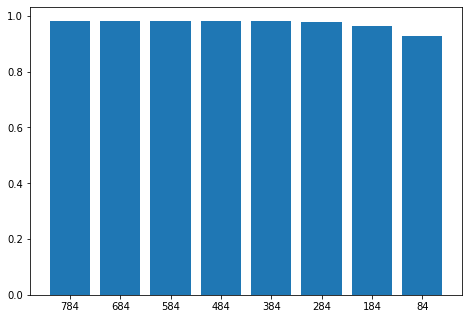

[0.9833274911194556, 0.9834330577794616, 0.9833843162327136, 0.9829967227188577, 0.9808585717165392, 0.9773578000593515, 0.9654346489397383, 0.9275296993840051]


In [ ]:
# ccr_conf = measurement(mu_star_conf_sorted_ind)
# with open("/content/drive/MyDrive/paper_data/morris_ccr_conf.pkl", 'wb') as handle:
#     pickle.dump(ccr_conf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
ccr_mu,ccr_mu_inv = measurement(mu_sorted_ind)
# ccr_mu_inv = measurement_inverse(mu_sorted_ind)

with open("/content/drive/MyDrive/paper_data/morris_ccr_mu.pkl", 'wb') as handle:
    pickle.dump(ccr_mu, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("/content/drive/MyDrive/paper_data/morris_ccr_mu_inv.pkl", 'wb') as handle:
    pickle.dump(ccr_mu_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
## 2- Sobol
from SALib.sample import saltelli
from SALib.analyze import sobol

X = saltelli.sample(problem, 300, calc_second_order=True)
X_img = X.reshape((-1,28,28))

<ipython-input-95-a373d078edc5>:5: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  X = saltelli.sample(problem, 300, calc_second_order=True)
/usr/local/lib/python3.10/dist-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (300) is equal to `2^n`.
        
  warnings.warn(msg)


In [ ]:
pred_list = []
for img in X_img:
    pred_list.append(batch_predict(img))# model function for prediction
pred_list = np.asarray(pred_list)
model_predict_test = np.argmax(pred_list,axis = 1)
# print(model_predict_test)

In [ ]:
Y = model_predict_test
Y = np.float64(Y)
Y = np.nan_to_num(Y).flatten()

si_sobol = sobol.analyze(problem, Y, print_to_console=False)

In [ ]:
s1_ind = si_sobol['S1'].reshape((28,28))
# s1conf_ind = si_sobol['S1_conf'].reshape((28,28))
# stconf_ind = si_sobol['ST_conf'].reshape((28,28))
st_ind = si_sobol['ST'].reshape((28,28))


In [ ]:
with open("/content/drive/MyDrive/paper_data/ccr/mnist_sobol_index1.pkl", 'wb') as handle:
    pickle.dump(s1_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/paper_data/ccr/mnist_sobol_index2.pkl", 'wb') as handle:
    pickle.dump(st_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)


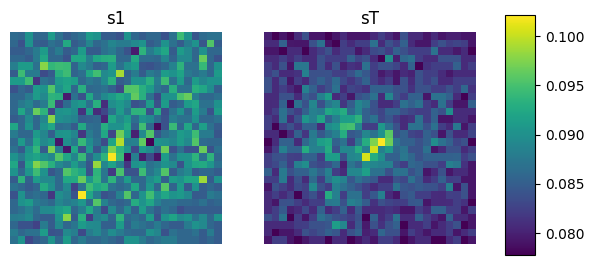

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(6,6))
ax[0].imshow(s1_ind)
ax[0].set_title('s1')
ax[0].axis('off')
ax[1].imshow(st_ind)
ax[1].set_title('sT')
ax[1].axis('off')
# ax[1].imshow(s1conf_ind)
# ax[1].set_title('s1conf')
# ax[1].axis('off')
# ax[2].imshow(stconf_ind)
# ax[2].set_title('stconf')
# ax[2].axis('off')
cbar_ax = fig.add_axes([0.95, 0.3, 0.05, 0.4])
fig.colorbar(t, cax=cbar_ax)
file_name = '/content/drive/MyDrive/paper_data/ccr/mnist_SA_sobol_sal'
fig.savefig(file_name,
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200,
            format='png')

In [ ]:
sobol_s1_sorted, sobol_s1_sorted_ind = sort_Si(si_sobol, 'S1', sortby='S1')
sobol_st_sorted, sobol_st_sorted_ind = sort_Si(si_sobol, 'ST', sortby='ST')


In [ ]:
ccr_sobol_s1,ccr_sobol_s1_inv = measurement(sobol_s1_sorted_ind)
# ccr_sobol_s1_inv = measurement_inverse(sobol_s1_sorted_ind)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_sobol_s1.pkl", 'wb') as handle:
    pickle.dump(ccr_sobol_s1, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_sobol_s1_inv.pkl", 'wb') as handle:
    pickle.dump(ccr_sobol_s1_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
ccr_sobol_st,ccr_sobol_st_inv = measurement(sobol_st_sorted_ind)
# ccr_sobol_st_inv = measurement_inverse(sobol_st_sorted_ind)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_sobol_st.pkl", 'wb') as handle:
    pickle.dump(ccr_sobol_st, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_sobol_st_inv.pkl", 'wb') as handle:
    pickle.dump(ccr_sobol_st_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
### 3- Derivative-based Global Sensitivity Measure (DGSM)
# from SALib.sample import finite_diff
# from SALib.analyze import dgsm
# X = finite_diff.sample(problem, 1000, delta=0.001)
# X_img = X.reshape((-1,28,28))


In [ ]:
# let's examine the results without delta parameter
from SALib.sample import finite_diff
from SALib.analyze import dgsm
X = finite_diff.sample(problem, 1000)
X_img = X.reshape((-1,28,28))


In [ ]:
pred_list = []
for img in X_img:
    pred_list.append(batch_predict(img))# model function for prediction
pred_list = np.asarray(pred_list)
model_predict_test = np.argmax(pred_list,axis = 1)
print(model_predict_test)

[8 8 8 ... 8 8 8]


In [ ]:
X.shape

(785000, 784)

In [ ]:
Y = model_predict_test
Y = np.float64(Y)
Y = np.nan_to_num(Y).flatten()

Si_dgsm = dgsm.analyze(problem, X, Y, conf_level=0.95, print_to_console=False)
# np.save('dgsm_analysis_'+str(hgroup)+'.npy', Si_dgsm)

In [ ]:
vi_ind = Si_dgsm['vi'].reshape((28,28))
# vi_std_ind = Si_dgsm['vi_std'].reshape((28,28))
dgsm_ind = Si_dgsm['dgsm'].reshape((28,28))
# dgsm_conf_ind = Si_dgsm['dgsm_conf'].reshape((28,28))

In [ ]:
with open("/content/drive/MyDrive/paper_data/ccr/mnist_dgsm_index1.pkl", 'wb') as handle:
    pickle.dump(vi_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/paper_data/ccr/mnist_dgsm_index2.pkl", 'wb') as handle:
    pickle.dump(dgsm_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)


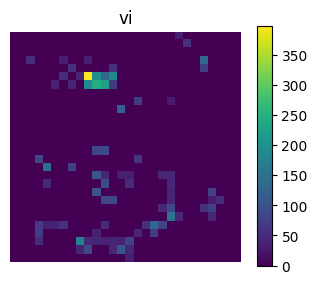

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
t=ax.imshow(vi_ind)
ax.set_title('vi')
ax.axis('off')
# ax[1].imshow(vi_std_ind)
# ax[1].set_title('vi_std')
# ax[1].axis('off')
# ax[2].imshow(dgsm_ind)
# ax[2].set_title('dgsm')
# ax[2].axis('off')
# ax[3].imshow(dgsm_conf_ind)
# ax[3].set_title('dgsm_conf')
# ax[3].axis('off')
cbar_ax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
fig.colorbar(t, cax=cbar_ax)
file_name = '/content/drive/MyDrive/paper_data/ccr/mnist_SA_dgsm_sal'
fig.savefig(file_name,
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200,
            format='png')

In [ ]:
Si_dgsm.keys()

dict_keys(['vi', 'vi_std', 'dgsm', 'dgsm_conf', 'names'])

In [ ]:
dgsm_vi_sorted, dgsm_vi_sorted_ind = sort_Si(Si_dgsm, 'vi', sortby='vi')
dgsm_dg_sorted, dgsm_dg_sorted_ind = sort_Si(Si_dgsm, 'dgsm', sortby='dgsm')


In [ ]:
ccr_dgsm_vi,ccr_dgsm_vi_inv = measurement(dgsm_vi_sorted_ind)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_dgsm_vi.pkl", 'wb') as handle:
    pickle.dump(ccr_dgsm_vi, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_dgsm_vi_inv.pkl", 'wb') as handle:
    pickle.dump(ccr_dgsm_vi_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
ccr_dgsm_dg,ccr_dgsm_dg_inv = measurement(dgsm_dg_sorted_ind)
# ccr_dgsm_dg_inv = measurement_inverse(dgsm_dg_sorted_ind)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_dgsm_dg.pkl", 'wb') as handle:
    pickle.dump(ccr_dgsm_dg, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_dgsm_dg_inv.pkl", 'wb') as handle:
    pickle.dump(ccr_dgsm_dg_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

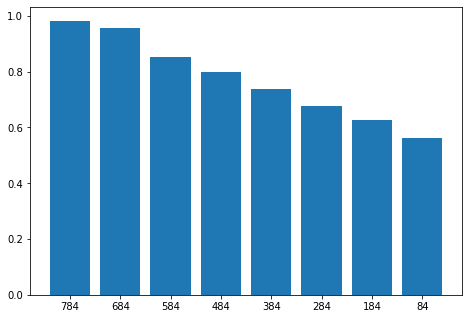

[0.9833274911194556, 0.9557487297285328, 0.8517618452040748, 0.7983894030325976, 0.7380076795059507, 0.6750771005705204, 0.6275830956982846, 0.563713725512883]


In [ ]:
# ccr_dgsm_conf = measurement(dgsm_conf_sorted_ind)
# with open("/content/drive/MyDrive/paper_data/ccr/ccr_dgsm_conf.pkl", 'wb') as handle:
#     pickle.dump(ccr_dgsm_conf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
### 4- FAST - Fourier Amplitude Sensitivity Test
from SALib.sample import fast_sampler
from SALib.analyze import fast
X = fast_sampler.sample(problem,100)



In [ ]:
X_img = X.reshape((-1,28,28))
pred_list = []
for img in X_img:
    pred_list.append(batch_predict(img))# model function for prediction
pred_list = np.asarray(pred_list)
model_predict_test = np.argmax(pred_list,axis = 1)
Y = model_predict_test
Y = np.float64(Y)
Y = np.nan_to_num(Y).flatten()

In [ ]:
for i in range(9): print(np.sum(model_predict_test==i))

60125
3857
401
355
292
2790
316
1827
8255


In [ ]:
Si_fast = fast.analyze(problem, Y, print_to_console=False)

/usr/local/lib/python3.10/dist-packages/SALib/analyze/fast.py:117: RuntimeWarning: invalid value encountered in scalar divide
  return (D1 / V), (1.0 - Dt / V)


In [ ]:
Si_fast.keys()

dict_keys(['S1', 'ST', 'S1_conf', 'ST_conf', 'names'])

In [ ]:
Si_fast['S1'] = np.asarray(Si_fast['S1'])
Si_fast['ST'] = np.asarray(Si_fast['ST'])

In [ ]:
S1_ind = Si_fast['S1'].reshape((28,28))
ST_ind = Si_fast['ST'].reshape((28,28))


In [ ]:
with open("/content/drive/MyDrive/paper_data/ccr/mnist_fast_index1.pkl", 'wb') as handle:
    pickle.dump(S1_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/paper_data/ccr/mnist_fast_index2.pkl", 'wb') as handle:
    pickle.dump(ST_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)

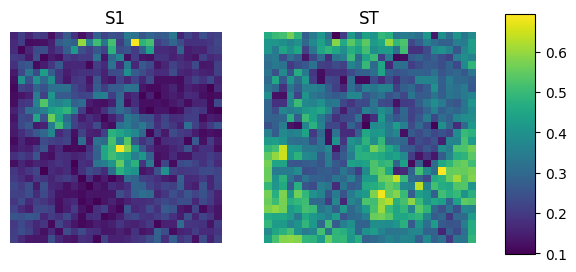

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(6,6))
ax[0].imshow(S1_ind)
ax[0].set_title('S1')
ax[0].axis('off')
t=ax[1].imshow(ST_ind)
ax[1].set_title('ST')
ax[1].axis('off')
cbar_ax = fig.add_axes([0.95, 0.3, 0.05, 0.4])
fig.colorbar(t, cax=cbar_ax)

file_name = '/content/drive/MyDrive/paper_data/ccr/mnist_SA_fast_sal'
fig.savefig(file_name,
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200,
            format='png')

In [ ]:
fast_s1_sorted,fast_s1_sorted_ind = sort_Si(Si_fast, 'S1', sortby='S1')
fast_st_sorted,fast_st_sorted_ind = sort_Si(Si_fast, 'ST', sortby='ST')


In [ ]:
ccr_fast_s1,ccr_fast_s1_inv = measurement(fast_s1_sorted_ind)
# ccr_fast_s1_inv = measurement_inverse(fast_s1_sorted_ind)

# with open("/content/drive/MyDrive/paper_data/ccr/ccr_fast_s1.pkl", 'wb') as handle:
#     pickle.dump(ccr_fast_s1, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open("/content/drive/MyDrive/paper_data/ccr/ccr_fast_s1_inv.pkl", 'wb') as handle:
#     pickle.dump(ccr_fast_s1_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
ccr_fast_s1,ccr_fast_s1_inv

([0.37942362326737916,
  0.5451071694301393,
  0.6471885066577944,
  0.7641425875188605,
  0.8913400069382316,
  0.9521292128832266,
  0.9771914604631201,
  0.9833274911194556],
 [0.32810739535020383,
  0.4246077889317233,
  0.6989784936602329,
  0.7865658873627293,
  0.8261543301336512,
  0.8549044266203436,
  0.9312840581190673,
  0.9833274911194556])

In [ ]:
ccr_fast_st,ccr_fast_st_inv = measurement(fast_st_sorted_ind)
# ccr_fast_st_inv = measurement_inverse(fast_st_sorted_ind)

# with open("/content/drive/MyDrive/paper_data/ccr/ccr_fast_st.pkl", 'wb') as handle:
#     pickle.dump(ccr_fast_st, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open("/content/drive/MyDrive/paper_data/ccr/ccr_fast_st_inv.pkl", 'wb') as handle:
#     pickle.dump(ccr_fast_st_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
ccr_fast_st,ccr_fast_st_inv

([0.1369451366277958,
  0.25722527085079816,
  0.40942936123810736,
  0.6189680390274498,
  0.7321384962807006,
  0.92162032344949,
  0.9715195194749622,
  0.9833274911194556],
 [0.34926097513566495,
  0.599256597853582,
  0.7566883730214067,
  0.8565206017435185,
  0.9398824733730061,
  0.9625268646182521,
  0.9795149114406669,
  0.9833274911194556])

In [ ]:
#### 5- RBD-FAST - Random Balance Designs Fourier Amplitude Sensitivity Test
from SALib.sample import latin
from SALib.analyze import rbd_fast
X = latin.sample(problem,400)


In [ ]:
X_img = X.reshape((-1,28,28))
pred_list = []
for img in X_img:
    pred_list.append(batch_predict(img))# model function for prediction
pred_list = np.asarray(pred_list)
model_predict_test = np.argmax(pred_list,axis = 1)
Y = model_predict_test
Y = np.float64(Y)
Y = np.nan_to_num(Y).flatten()

In [ ]:
for i in range(9): print(np.sum(model_predict_test==i))

57
0
4
3
0
1
0
0
335


In [ ]:
from SALib.analyze import rbd_fast

Si_rbd = rbd_fast.analyze(problem,X, Y, print_to_console=False)

In [ ]:
Si_rbd.keys()

dict_keys(['S1', 'S1_conf', 'names'])

In [ ]:
Si_rbd['S1'] = np.asarray(Si_rbd['S1'])
S1_ind = Si_rbd['S1'].reshape((28,28))


In [ ]:
with open("/content/drive/MyDrive/paper_data/ccr/mnist_rbd_index1.pkl", 'wb') as handle:
    pickle.dump(S1_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# test loading
# with open('/content/drive/MyDrive/paper_data/ccr/mnist_rbd_index1.pkl', 'rb') as handle:
#       test_ind = pickle.load(handle)


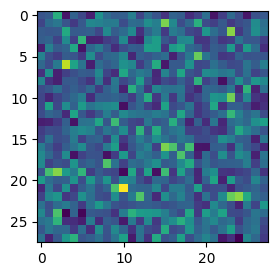

In [ ]:
# test visualizing
# fig,ax = plt.subplots(1,1,figsize=(3,3))
# t=ax.imshow(test_ind)

In [ ]:
S1_ind.shape

(28, 28)

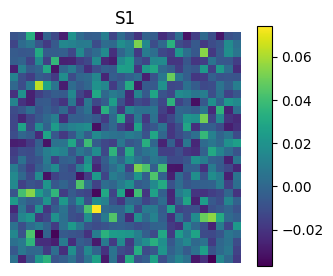

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
t=ax.imshow(S1_ind)
ax.set_title('S1')
ax.axis('off')
cbar_ax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
fig.colorbar(t, cax=cbar_ax)
file_name = '/content/drive/MyDrive/paper_data/ccr/mnist_SA_rbd_sal'
fig.savefig(file_name,
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200,
            format='png')

In [ ]:
rbd_s1_sorted,rbd_s1_sorted_ind = sort_Si(Si_rbd, 'S1', sortby='S1')


In [ ]:
ccr_rbd_s1,ccr_rbd_s1_inv = measurement(rbd_s1_sorted_ind)
# ccr_rbd_s1_inv = measurement_inverse(rbd_s1_sorted_ind)

with open("/content/drive/MyDrive/paper_data/rbd_s1.pkl", 'wb') as handle:
    pickle.dump(ccr_rbd_s1, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("/content/drive/MyDrive/paper_data/rbd_s1_inv.pkl", 'wb') as handle:
    pickle.dump(ccr_rbd_s1_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#### 6- Delta Moment-Independent Measure
from SALib.sample import latin
from SALib.analyze import delta
X = latin.sample(problem,1000)


In [ ]:
X_img = X.reshape((-1,28,28))
pred_list = []
for img in X_img:
    pred_list.append(batch_predict(img))# model function for prediction
pred_list = np.asarray(pred_list)
model_predict_test = np.argmax(pred_list,axis = 1)
Y = model_predict_test
Y = np.float64(Y)
Y = np.nan_to_num(Y).flatten()


In [ ]:
model_predict_test.shape

(1000,)

In [ ]:
for i in range(9): print(np.sum(model_predict_test==i))

156
0
14
1
0
0
0
0
829


In [ ]:
Si_delta = delta.analyze(problem,X, Y, print_to_console=False)

In [ ]:
type(Si_delta['delta'])

numpy.ndarray

In [ ]:
delta_ind = Si_delta['delta'].reshape((28,28))
# deltaconf_ind = Si_delta['delta_conf'].reshape((28,28))
deltaS1_ind = Si_delta['S1'].reshape((28,28))
# deltaS1conf_ind = Si_delta['S1_conf'].reshape((28,28))

In [ ]:
with open("/content/drive/MyDrive/paper_data/ccr/mnist_delta_index1.pkl", 'wb') as handle:
    pickle.dump(delta_ind, handle, protocol=pickle.HIGHEST_PROTOCOL)


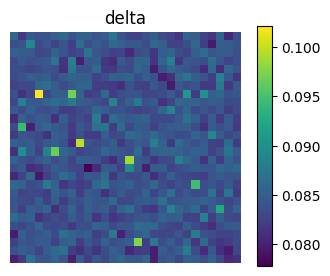

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
t = ax.imshow(delta_ind)
ax.set_title('delta')
ax.axis('off')
# ax[1].imshow(deltaconf_ind)
# ax[1].set_title('delta_conf')
# ax[1].axis('off')
# ax[1].imshow(deltaS1_ind)
# ax[1].set_title('S1')
# ax[1].axis('off')
cbar_ax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
fig.colorbar(t, cax=cbar_ax)
# ax[3].imshow(deltaS1conf_ind)
# ax[3].set_title('S1_conf')
# ax[3].axis('off')
file_name = '/content/drive/MyDrive/paper_data/ccr/mnist_SA_delta_sal'
fig.savefig(file_name,
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200,
            format='png')

In [ ]:
delta_d_sorted,delta_d_sorted_ind = sort_Si(Si_delta, 'delta', sortby='delta')
# delta_conf_sorted,delta_conf_sorted_ind = sort_Si(Si_delta, 'delta_conf', sortby='delta_conf')
delta_s1_sorted,delta_s1_sorted_ind = sort_Si(Si_delta, 'S1', sortby='S1')
# delta_s1conf_sorted,delta_s1conf_sorted_ind = sort_Si(Si_delta, 'S1_conf', sortby='S1_conf')

In [ ]:
ccr_delta_d,ccr_delta_d_inv = measurement(delta_d_sorted_ind)
# ccr_delta_d_inv = measurement_inverse(delta_d_sorted_ind)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_delta_d.pkl", 'wb') as handle:
    pickle.dump(ccr_delta_d, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_delta_d_inv.pkl", 'wb') as handle:
    pickle.dump(ccr_delta_d_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# ccr_delta_conf = measurement(delta_conf_sorted_ind)
# with open("/content/drive/MyDrive/paper_data/ccr/ccr_delta_conf.pkl", 'wb') as handle:
#     pickle.dump(ccr_delta_conf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
ccr_delta_s1,ccr_delta_s1_inv = measurement(delta_s1_sorted_ind)
# ccr_delta_s1_inv = measurement_inverse(delta_s1_sorted_ind)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_delta_s1.pkl", 'wb') as handle:
    pickle.dump(ccr_delta_s1, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("/content/drive/MyDrive/paper_data/ccr/ccr_delta_s1_inv.pkl", 'wb') as handle:
    pickle.dump(ccr_delta_s1_inv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('/content/drive/MyDrive/paper_data/ccr/morris_ccr_mu_star.pkl', 'rb') as handle:
      ccr_mu_star = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/morris_ccr_sigma.pkl', 'rb') as handle:
      ccr_sigma = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/morris_ccr_mu.pkl', 'rb') as handle:
      ccr_mu = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_sobol_s1.pkl', 'rb') as handle:
      ccr_sobol_s1 = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_sobol_st.pkl', 'rb') as handle:
      ccr_sobol_st = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_dgsm_vi.pkl', 'rb') as handle:
      ccr_dgsm_vi = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_dgsm_dg.pkl', 'rb') as handle:
      ccr_dgsm_dg = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_fast_s1.pkl', 'rb') as handle:
      ccr_fast_s1 = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_fast_st.pkl', 'rb') as handle:
      ccr_fast_st = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/rbd_s1.pkl', 'rb') as handle:
      ccr_rbd_s1 = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_delta_d.pkl', 'rb') as handle:
      ccr_delta_d = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_delta_s1.pkl', 'rb') as handle:
      ccr_delta_s1 = pickle.load(handle)

with open('/content/drive/MyDrive/paper_data/ccr/morris_ccr_mu_star_inv.pkl', 'rb') as handle:
      ccr_mu_star_inv = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/morris_ccr_sigma_inv.pkl', 'rb') as handle:
      ccr_sigma_inv = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/morris_ccr_mu_inv.pkl', 'rb') as handle:
      ccr_mu_inv = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_sobol_s1_inv.pkl', 'rb') as handle:
      ccr_sobol_s1_inv = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_sobol_st_inv.pkl', 'rb') as handle:
      ccr_sobol_st_inv = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_dgsm_vi_inv.pkl', 'rb') as handle:
      ccr_dgsm_vi_inv = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_dgsm_dg_inv.pkl', 'rb') as handle:
      ccr_dgsm_dg_inv = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_fast_s1_inv.pkl', 'rb') as handle:
      ccr_fast_s1_inv = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_fast_st_inv.pkl', 'rb') as handle:
      ccr_fast_st_inv = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/rbd_s1_inv.pkl', 'rb') as handle:
      ccr_rbd_s1_inv = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_delta_d_inv.pkl', 'rb') as handle:
      ccr_delta_d_inv = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/ccr_delta_s1_inv.pkl', 'rb') as handle:
      ccr_delta_s1_inv = pickle.load(handle)

In [ ]:
def subtract_list(list1,list2):
    difference = []
    zip_object = zip(list1, list2)

    for list1_i, list2_i in zip_object:

        difference.append(list1_i-list2_i)
    return(difference)

In [ ]:
s = subtract_list(ccr_mu_star,ccr_mu_star_inv)
type(s)

list

In [ ]:

mu_star_diff = subtract_list(ccr_mu_star,ccr_mu_star_inv)
sigma_diff = subtract_list(ccr_sigma,ccr_sigma_inv)
mu_diff = subtract_list(ccr_mu,ccr_mu_inv)
sobol_s1_diff = subtract_list(ccr_sobol_s1,ccr_sobol_s1_inv)
ccr_dgsm_vi_diff = subtract_list(ccr_dgsm_vi,ccr_dgsm_vi_inv)
ccr_dgsm_dg_diff = subtract_list(ccr_dgsm_dg,ccr_dgsm_dg_inv)
ccr_fast_s1_diff = subtract_list(ccr_fast_s1,ccr_fast_s1_inv)
ccr_fast_st_diff = subtract_list(ccr_fast_st,ccr_fast_st_inv)
ccr_delta_d_diff = subtract_list(ccr_delta_d,ccr_delta_d_inv)
ccr_delta_s1_diff = subtract_list(ccr_delta_s1,ccr_delta_s1_inv)

In [ ]:
ac2 = AgglomerativeClustering(n_clusters = 2)

# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(X_principal['P1'], X_principal['P2'],
           c = ac2.fit_predict(X_principal), cmap ='rainbow')
plt.show()

In [ ]:
with open('/content/drive/MyDrive/paper_data/ccr/mnist_morris_index1.pkl', 'rb') as handle:
      morris_ind1 = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/mnist_morris_index2.pkl', 'rb') as handle:
      morris_ind2 = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/mnist_morris_index3.pkl', 'rb') as handle:
      morris_ind3 = pickle.load(handle)

with open('/content/drive/MyDrive/paper_data/ccr/mnist_sobol_index1.pkl', 'rb') as handle:
      sobol_ind1 = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/mnist_sobol_index2.pkl', 'rb') as handle:
      sobol_ind2 = pickle.load(handle)

with open('/content/drive/MyDrive/paper_data/ccr/mnist_fast_index1.pkl', 'rb') as handle:
      fast_ind1 = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/mnist_fast_index2.pkl', 'rb') as handle:
      fast_ind2 = pickle.load(handle)

with open('/content/drive/MyDrive/paper_data/ccr/mnist_rbd_index1.pkl', 'rb') as handle:
      rbd_ind1 = pickle.load(handle)

with open('/content/drive/MyDrive/paper_data/ccr/mnist_dgsm_index1.pkl', 'rb') as handle:
      dgsm_ind1 = pickle.load(handle)
with open('/content/drive/MyDrive/paper_data/ccr/mnist_dgsm_index2.pkl', 'rb') as handle:
      dgsm_ind2 = pickle.load(handle)

with open('/content/drive/MyDrive/paper_data/ccr/mnist_delta_index1.pkl', 'rb') as handle:
      delta_ind1 = pickle.load(handle)


In [ ]:
def visulaize(i,j,ind,titl):
    a = ax[i][j].imshow(ind)
    ax[i][j].set_title(titl,fontsize = 8)
    ax[i][j].axis('off')
    return a

<ipython-input-159-e1357aec5bc2>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


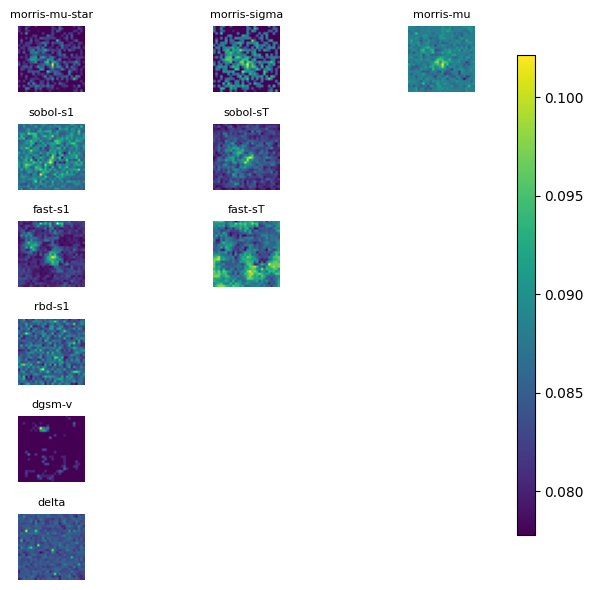

In [ ]:
fig,ax = plt.subplots(6,3,figsize=(6,6))
visulaize(0,0,morris_ind1,"morris-mu-star")
visulaize(0,1,morris_ind2,"morris-sigma")
visulaize(0,2,morris_ind3,"morris-mu")

visulaize(1,0,sobol_ind1,"sobol-s1")
visulaize(1,1,sobol_ind2,"sobol-sT")
ax[1][2].set_visible(False)

visulaize(2,0,fast_ind1,"fast-s1")
visulaize(2,1,fast_ind2,"fast-sT")
ax[2][2].set_visible(False)

visulaize(3,0,rbd_ind1,"rbd-s1")
ax[3][1].set_visible(False)
ax[3][2].set_visible(False)

visulaize(4,0,dgsm_ind1,"dgsm-v")
# visulaize(1,1,sobol_ind2,"dgsm")
ax[4][1].set_visible(False)
ax[4][2].set_visible(False)

a = visulaize(5,0,delta_ind1,"delta")
ax[5][1].set_visible(False)
ax[5][2].set_visible(False)




cbar_ax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(a, cax=cbar_ax)
fig.tight_layout()

file_name = '/content/drive/MyDrive/paper_data/ccr/mnist_all_indexes_sal'
fig.savefig(file_name,
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200,
            format='png')